In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

# Dataset

### Defining dataset

In [2]:
data_path = "databases/AffectNet"

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(70),
    transforms.Resize((96, 96)),
    transforms.Normalize(mean = mean, std = std),
])


dataset = ImageFolder(data_path, transform=transform)

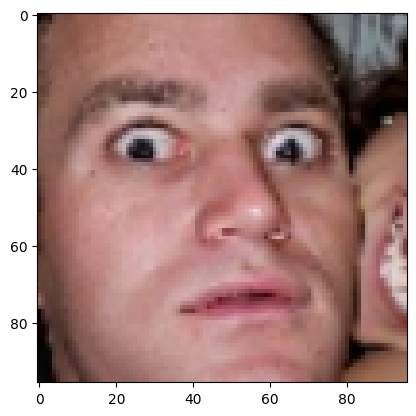

In [4]:
idx = np.random.choice(len(dataset))
image, label = dataset[idx]
image = image.permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)

plt.imshow(image)

In [5]:
label2id = dataset.class_to_idx
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

Class Weights: [0.13268187 0.14871831 0.17237394 0.13443648 0.08464914 0.08329502
 0.13813337 0.10571187]


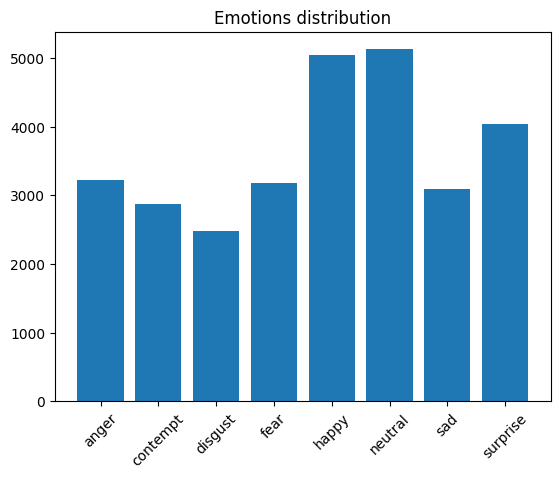

In [6]:
# Calculate class weights as the inverse of class frequencies
counter = np.bincount(dataset.targets)
class_weights = 1.0 / counter

# Normalize the weights by dividing by the sum of the weights
normalized_weights = class_weights / np.sum(class_weights)

# Output the weights
print("Class Weights:", normalized_weights)
plt.bar(range(len(counter)), counter)
plt.xticks(range(len(counter)), [id2label[i] for i in range(len(counter))], rotation=45)
plt.xticks(rotation=45)
plt.title("Emotions distribution")
plt.show()

In [7]:
from torch.utils.data import random_split
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder



def get_loaders(data_path, batch_size=32, train_size=0.8):
    # Load the original dataset without transforms
    base_dataset = ImageFolder(data_path)
    
    # Calculate split sizes
    total_size = len(base_dataset)
    test_val_size = int((1 - train_size) * total_size / 2)
    train_size = total_size - 2 * test_val_size
    
    # Generate consistent indices for splitting
    gen1 = torch.Generator().manual_seed(42)
    train_indices, val_indices, test_indices = random_split(
        range(total_size), [train_size, test_val_size, test_val_size], generator=gen1
    )
    
    # Create separate datasets with different transformations
    train_dataset = Subset(ImageFolder(data_path, transform=transform), train_indices)
    val_dataset = Subset(ImageFolder(data_path, transform=transform), val_indices)
    test_dataset = Subset(ImageFolder(data_path, transform=transform), test_indices)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader, val_loader, test_loader


Text(0.5, 1.0, 'disgust')

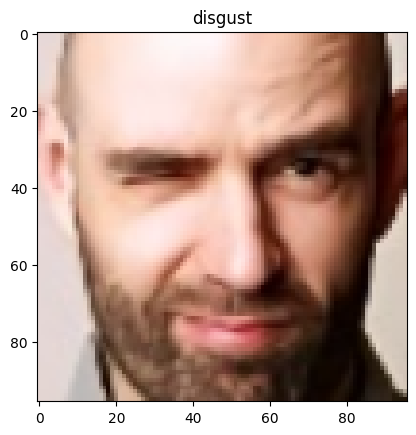

In [8]:
train_loader, val_loader, test_loader = get_loaders(data_path)
train_sample = next(iter(train_loader))
image, label = train_sample[0][5], train_sample[1][5]
image = image.permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
label = id2label[label.item()]
plt.imshow(image)
plt.title(label)

# Defining the model

In [9]:
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
from torchvision.models import resnet18, ResNet18_Weights

class Net2D(nn.Module):
    def __init__(self, out_size):
        super(Net2D, self).__init__()
        self.back = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),
            nn.Dropout2d(0.3),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 4, 32), nn.Dropout(0.3), nn.ReLU(), nn.Linear(32, out_size)
        )

        # Initialize weights using Kaiming initialization
        for conv_layer in self.back:
            if isinstance(conv_layer, nn.Conv2d):
                nn.init.kaiming_normal_(conv_layer.weight)
        for fc_layer in self.fc:
            if isinstance(fc_layer, nn.Linear):
                nn.init.kaiming_normal_(fc_layer.weight)

    def forward(self, x):
        x = self.back(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Example usage
model = Net2D(len(label2id))
device = torch.device("mps")
model = model.to(device)
sample = torch.rand(64, 3, 96, 96).to(device)
print(model(sample).shape)

params = 0
for p in model.parameters():
    params += p.numel()

f"params: {params:,}", model

torch.Size([64, 8])


('params: 440,808',
 Net2D(
   (back): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): Dropout2d(p=0.3, inplace=False)
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
     (4): ReLU()
     (5): Dropout2d(p=0.3, inplace=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (7): ReLU()
     (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     (9): Dropout2d(p=0.3, inplace=False)
     (10): ReLU()
     (11): AdaptiveMaxPool2d(output_size=2)
   )
   (fc): Sequential(
     (0): Linear(in_features=1024, out_features=32, bias=True)
     (1): Dropout(p=0.3, inplace=False)
     (2): ReLU()
     (3): Linear(in_features=32, out_features=8, bias=True)
   )
 ))

In [10]:
batch_size = 256
train_loader, val_loader, test_loader = get_loaders(
    data_path, batch_size=batch_size, train_size=0.8
)

In [11]:
from utils import train_model, evaluate
device = torch.device("mps")
epochs = 500

model = Net2D(len(label2id))
model = model.to(device)
weight_tensor = torch.tensor(normalized_weights, dtype = torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=epochs)
logdir = "logs/Net2D_100_64/"
save_path = logdir + "best_model.pth"

TRAIN_LOSSES, VAL_LOSSES = [], []

In [12]:
#train_losses, val_losses = train_model(
#    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, save_path, logdir, patience=20
#)

In [15]:
best_model_path = "models/Net2D-pretrain.pth"
model.load_state_dict(torch.load(best_model_path, weights_only=True))
acc, f1, precision, recall, cm = evaluate(model, test_loader, device)

[Text(0, 0, 'anger'),
 Text(0, 1, 'contempt'),
 Text(0, 2, 'disgust'),
 Text(0, 3, 'fear'),
 Text(0, 4, 'happy'),
 Text(0, 5, 'neutral'),
 Text(0, 6, 'sad'),
 Text(0, 7, 'surprise')]

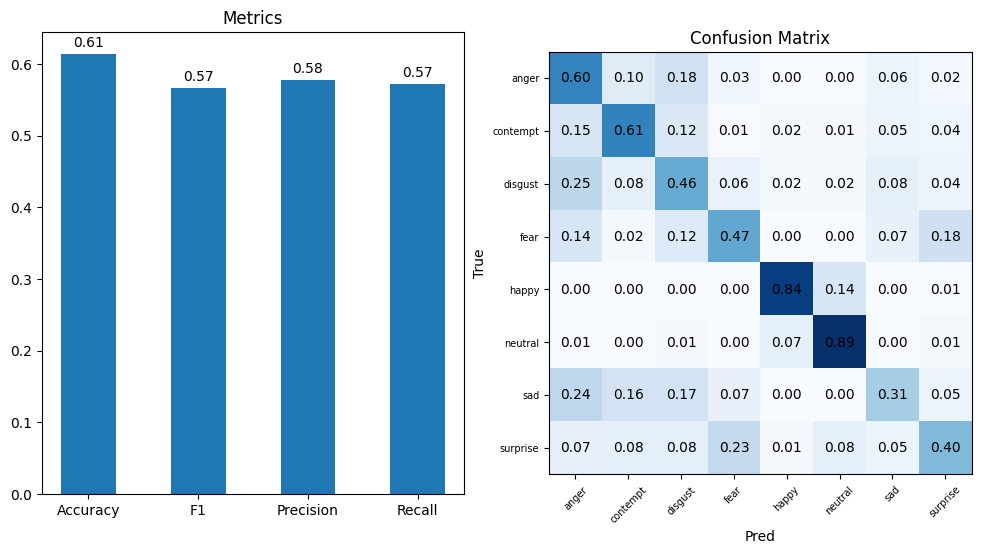

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#axis 1 is barplot, axis 2 is confusion matrix
ax[0].bar(range(4), [acc, f1, precision, recall], width=0.5)
for i, v in enumerate([acc, f1, precision, recall]):
    ax[0].text(i, v + 0.01, f"{v:.2f}", ha="center")

ax[0].set_xticks(range(4))
ax[0].set_xticklabels(["Accuracy", "F1", "Precision", "Recall"])
ax[0].set_title("Metrics")

ax[1].imshow(cm, cmap="Blues")
for i in range(len(cm)):
    for j in range(len(cm[0])):
        ax[1].text(j, i, f"{cm[i][j]:.2f}", ha="center", va="center")
    
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Pred")
ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(id2label)))
ax[1].set_xticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)
ax[1].set_yticks(range(len(id2label)))
ax[1].set_yticklabels([id2label[i] for i in range(len(id2label))], fontsize=7)